# Análise e Clustering de Super-Heróis
Este notebook realiza a análise exploratória e clustering (KMeans) do dataset de habilidades dos super-heróis.


Objetivos:
- Explorar distribuições e correlações entre atributos.
- Encontrar um número adequado de grupos (k) usando Elbow + Silhouette.
- Interpretar os clusters com base nos centroides em escala original.

In [41]:
import os
import warnings
import kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Estilo dos plots
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (8,6)

In [42]:
path = kagglehub.dataset_download("hemajitpatel/superheros-abilities-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'superheros-abilities-dataset' dataset.
Path to dataset files: /kaggle/input/superheros-abilities-dataset
['superhero_abilities_dataset.csv']


In [43]:
data = pd.read_csv(os.path.join(path, 'superhero_abilities_dataset.csv'))
display(data.head(10))
print('\nShape:', data.shape)
print('\nColunas:', data.columns.tolist())

,Name,Universe,Alignment,Strength,Speed,Intelligence,Combat Skill,Weapon,Power Score,Popularity Score
0,Iron Man #1,Marvel,Anti-Hero,1.0,1.0,2.0,5,Sword,65,40
1,Batman #1,DC,Anti-Hero,5.0,4.0,6.0,2,Shield,94,98
2,Joker #1,Marvel,Hero,3.0,9.0,2.0,5,Hammer,62,40
3,Thor #1,Marvel,Hero,1.0,6.0,2.0,8,Claws,83,91
4,Thanos #1,Marvel,Villain,4.0,3.0,2.0,9,Claws,78,77
5,Wonder Woman #1,DC,Hero,5.0,1.0,NaN,2,Shield,54,33
6,Spider-Man #1,Marvel,Anti-Hero,7.0,NaN,2.0,3,Claws,95,6
7,Green Lantern #1,Marvel,Anti-Hero,1.0,9.0,4.0,3,Bow,88,88
8,Deadpool #1,Marvel,Hero,3.0,3.0,9.0,1,Hammer,43,19
9,Black Panther #1,DC,Anti-Hero,2.0,9.0,6.0,8,Psychic,68,80



Shape: (200, 10)

Colunas: ['Name', 'Universe', 'Alignment', 'Strength', 'Speed', 'Intelligence', 'Combat Skill', 'Weapon', 'Power Score', 'Popularity Score']


In [44]:
print(data.isnull().sum())

Name                 0
Universe             0
Alignment            0
Strength            10
Speed               10
Intelligence        10
Combat Skill         0
Weapon              29
Power Score          0
Popularity Score     0
dtype: int64


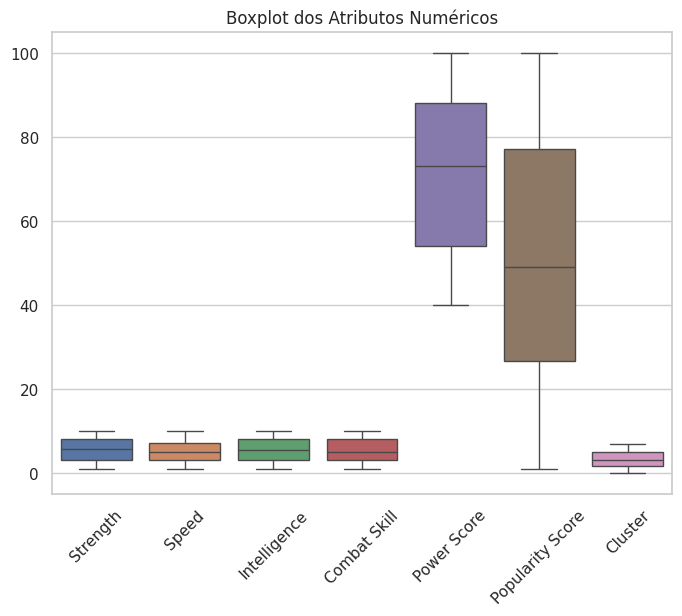

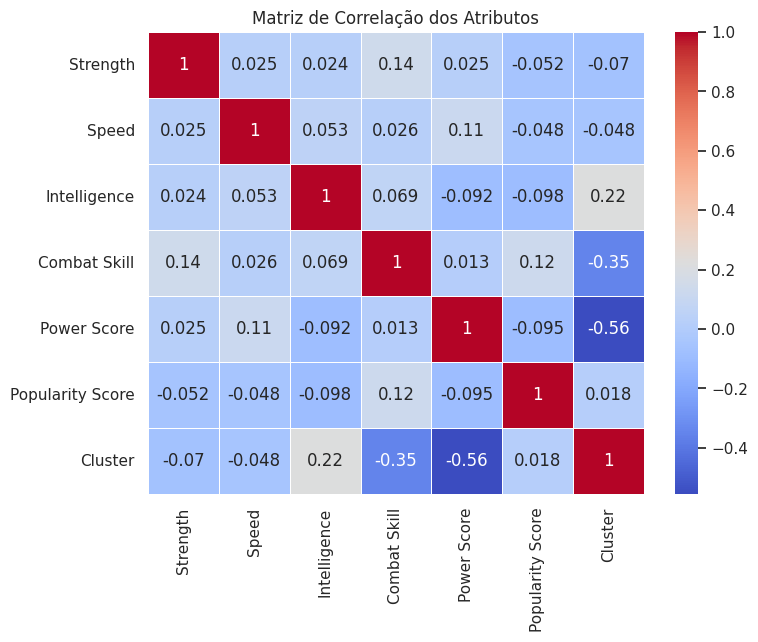

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_data = data.select_dtypes(include=['number'])

plt.figure(figsize=(8,6))
sns.boxplot(data=numeric_data)
plt.title("Boxplot dos Atributos Numéricos")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Correlação dos Atributos")
plt.show()


In [46]:
data = data.fillna(data.mean(numeric_only=True))
print(data.isnull().sum())

Name                 0
Universe             0
Alignment            0
Strength             0
Speed                0
Intelligence         0
Combat Skill         0
Weapon              29
Power Score          0
Popularity Score     0
dtype: int64


In [47]:
features = [
    "Strength",
    "Speed",
    "Intelligence",
    "Combat Skill",
    "Power Score"
]

X = data[features]

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

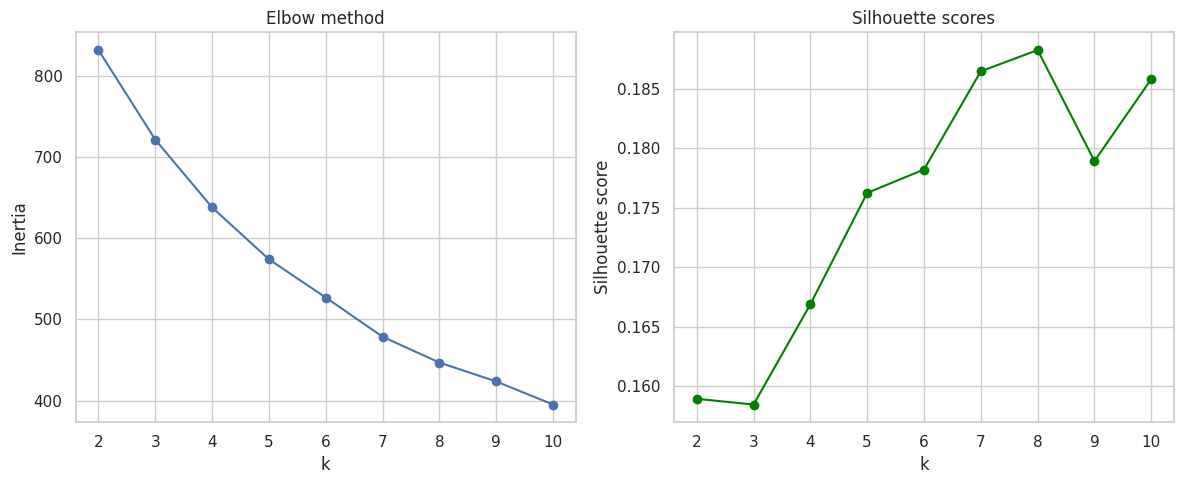

Melhor k (maior silhouette): 8

Centroides (em escala original):


,Strength,Speed,Intelligence,Combat Skill,Power Score
0,3.051417,8.359717,4.043725,6.807692,81.423077
1,8.305702,5.142105,3.166667,7.041667,86.750000
2,6.505433,4.990492,8.935484,5.129032,85.612903
3,7.416729,3.310902,5.754887,8.107143,55.928571
4,3.102632,3.192308,4.197571,3.192308,84.076923
5,5.481579,3.055556,2.642690,2.000000,51.055556
6,8.493474,8.560000,6.148211,4.560000,65.560000
7,2.454545,5.925120,8.363636,5.090909,50.954545


In [49]:
# Seleção de k: Elbow + Silhouette (usa X_scaled gerado anteriormente)
inertia = []
silhouettes = []
K_range = range(2,11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels_k))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertia, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow method')

plt.subplot(1,2,2)
plt.plot(list(K_range), silhouettes, marker='o', color='green')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores')
plt.tight_layout()
plt.show()

best_k = K_range[np.argmax(silhouettes)]
print(f"Melhor k (maior silhouette): {best_k}")

# Recalcula KMeans com melhor k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)
data["Cluster"] = labels

# Centroides em escala original
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=features)
print("\nCentroides (em escala original):")
display(centroid_df)

In [50]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

data_pca = pd.DataFrame(
    data=pca_result,
    index=X.index.copy()
)
data_pca.columns = [
    'PC' + str(col+1) for col in data_pca.columns
]
data_pca['Cluster'] = labels
data_pca.head()

,PC1,PC2,Cluster
0,-2.050191,-0.168702,4
1,-0.760608,0.856718,4
2,-0.624015,0.867333,0
3,-0.539091,1.113117,0
4,-0.184144,0.336429,1


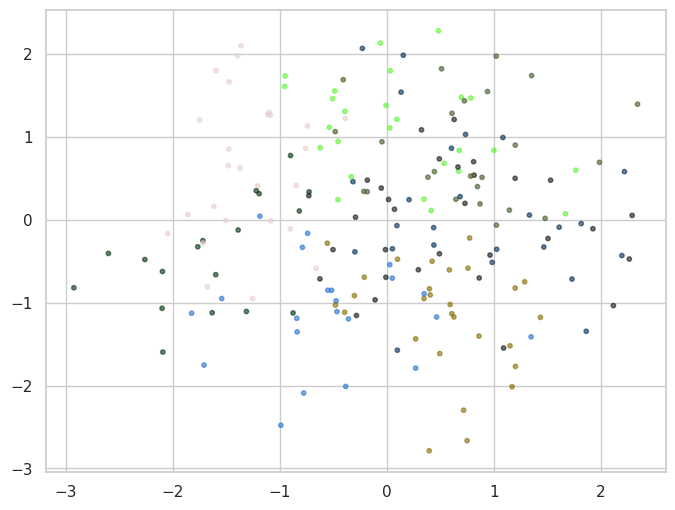

In [51]:
import matplotlib.pyplot as plt

colors = ['#5DF534', '#425B26', '#151716', '#876E03', '#E8CECF', '#023411', '#042E54', '#2572D3', '#FD0D0C', '#169C90']
data_pca['color'] = data_pca['Cluster'].map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[5], 6:colors[6], 7:colors[7], 8:colors[8], 9:colors[9]})

plt.scatter(data_pca['PC1'], data_pca['PC2'], c=data_pca['color'], alpha = 0.6, s=10)

In [52]:
# Com 3 componentes
pca = PCA(n_components=3)
pca_array = pca.fit_transform(X_scaled)

# Converte em dataframe
df_pca = pd.DataFrame(data=pca_array, index=X.index.copy())
df_pca.columns = ['PC' + str(col+1) for col in df_pca.columns.values]
df_pca['Cluster'] = labels

df_pca.head()

,PC1,PC2,PC3,Cluster
0,-2.050191,-0.168702,-0.954082,4
1,-0.760608,0.856718,0.141209,4
2,-0.624015,0.867333,0.489864,0
3,-0.539091,1.113117,-0.187962,0
4,-0.184144,0.336429,-1.362250,1


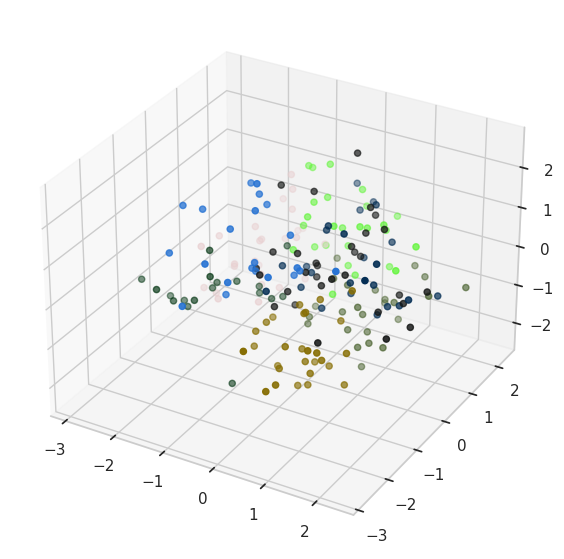

In [55]:
# Import libraries
from mpl_toolkits import mplot3d

df_pca['color'] = df_pca['Cluster'].map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[5], 6:colors[6], 7:colors[7], 8:colors[8], 9:colors[9]})

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=df_pca['color'])

# show plot
plt.show()

In [54]:
cluster_summary = data.groupby("Cluster")[features].mean()
print("\n=== MÉDIA DOS ATRIBUTOS POR CLUSTER ===")
print(cluster_summary)


=== MÉDIA DOS ATRIBUTOS POR CLUSTER ===
         Strength     Speed  Intelligence  Combat Skill  Power Score
Cluster                                                             
0        3.051417  8.359717      4.043725      6.807692    81.423077
1        8.305702  5.142105      3.166667      7.041667    86.750000
2        6.505433  4.990492      8.935484      5.129032    85.612903
3        7.416729  3.310902      5.754887      8.107143    55.928571
4        3.102632  3.192308      4.197571      3.192308    84.076923
5        5.481579  3.055556      2.642690      2.000000    51.055556
6        8.493474  8.560000      6.148211      4.560000    65.560000
7        2.454545  5.925120      8.363636      5.090909    50.954545
